In [5]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## GPU 사용

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


## 데이터 준비

In [ ]:
transform = transforms.ToTensor()
train_DS = datasets.MNIST(root = './data', train=True, download=True, transform=transform)
test_DS = datasets.MNIST(root = './data', train=False, download=True, transform=transform)

In [ ]:
print(train_DS)
print(test_DS)
print(len(train_DS))
print(len(test_DS))

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [10]:
train_DS.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [11]:
train_DS.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [13]:
train_DS.data.shape

torch.Size([60000, 28, 28])

In [14]:
train_DS.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

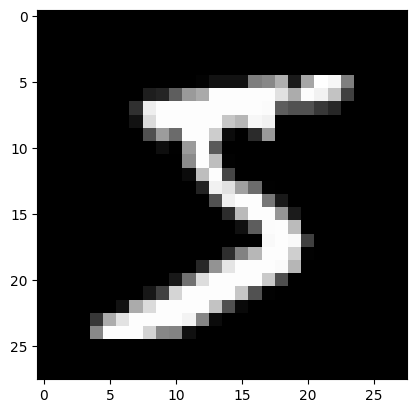

In [16]:
plt.imshow(train_DS.data[0], cmap='gray')
plt.show()

In [17]:
print(train_DS.targets)
print(train_DS.targets.shape)

tensor([5, 0, 4,  ..., 5, 6, 8])
torch.Size([60000])


## DataLoader 만들기

In [18]:
BATCH_SIZE = 32
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([60000, 28, 28])
torch.Size([32, 1, 28, 28])


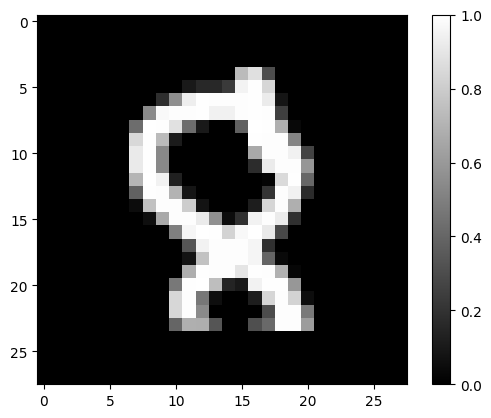

In [34]:
x_batch, y_batch = next(iter(train_DL)) # 데이터 한 배치

# print(type(train_DS.data))
print(train_DS.data.shape)
# print(train_DS.data.dtype)
# print(train_DS.data[0])

# print(type(x_batch))
print(x_batch.shape)
# print(x_batch.dtype)
# print(x_batch[0])

plt.imshow(x_batch[0].squeeze(), cmap='gray')
plt.colorbar()
plt.show()

## 모델 만들기

In [35]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcs  = nn.Sequential(nn.Linear(28 * 28, 100),
                                  nn.ReLU(),
                                  nn.Linear(100, 10))
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fcs(x)
        return x   

In [36]:
# flatten 확인
x_batch, _ = next(iter(train_DL))
print(x_batch.shape)
flat_image = torch.flatten(x_batch)
print(flat_image.shape)
flat_image2 = torch.flatten(x_batch, start_dim=1)
print(flat_image2.shape)

torch.Size([32, 1, 28, 28])
torch.Size([25088])
torch.Size([32, 784])


In [39]:
model = MLP().to(DEVICE)
print(model)
x_batch, _ = next(iter(train_DL))
print(model(x_batch.to(DEVICE)).shape)

MLP(
  (fcs): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
torch.Size([32, 10])


## 모델 훈련하기

In [45]:
from torch import optim

LR = 1e-3
EPOCH = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def train(model, train_DL, criterion, optimizer, EPOCH):
    
    loss_history = []
    NoT = len(train_DL.dataset)
    
    model.train() # train mode로 전환
    for ep in range(EPOCH):
        rloss = 0 # running loss
        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            # inference
            y_hat = model(x_batch)
            
            # loss
            loss = criterion(y_hat, y_batch)
            
            # update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # loss accumuation
            loss_b = loss.item() * x_batch.shape[0]
            rloss += loss_b
        
        # print loss
        loss_e = rloss/NoT # epoch loss
        loss_history += [loss_e]
        print(f'Epoch: {ep+1}, train loss: {loss_e:.3f}')
        print('-' * 20)
        
    return loss_history

Epoch: 1, train loss: 0.010
--------------------
Epoch: 2, train loss: 0.008
--------------------
Epoch: 3, train loss: 0.008
--------------------
Epoch: 4, train loss: 0.008
--------------------
Epoch: 5, train loss: 0.007
--------------------


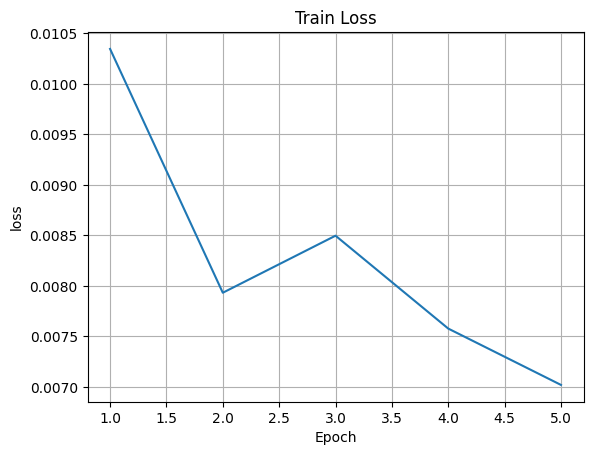

In [48]:
loss_history = train(model, train_DL, criterion, optimizer, EPOCH)

plt.plot(range(1, EPOCH+1), loss_history)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Train Loss')
plt.grid()

모델 저장하기 & 불러오기

In [50]:
save_model_path = './results/MLP.pt'
torch.save(model.state_dict(), save_model_path)

In [51]:
load_model = MLP().to(DEVICE)
load_model.load_state_dict(torch.load(save_model_path, map_location=DEVICE))

C:\Users\jyj1206\AppData\Local\Temp\ipykernel_14716\2190178740.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model.load_state_dict(torch.load(save_model_path, map

<All keys matched successfully>

모델 테스트하기

In [58]:
def Test(model, test_DL):
    model.eval() # test mode로 변환
    with torch.no_grad():
        rcorrect = 0
        for x_batch, y_batch in test_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            # inference
            y_hat = model(x_batch)
            
            # corrects accumulation
            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b
        accuracy_e = rcorrect/len(test_DL.dataset) * 100
    print(f'Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({accuracy_e:.1f})')
    return round(accuracy_e, 1)

In [59]:
Test(load_model, test_DL)

Test accuracy: 9747/10000 (97.5)


97.5

In [66]:
def Test_plot(model, test_DL):
    model.eval()
    with torch.no_grad():
        x_batch, y_batch = next(iter(test_DL))
        x_batch = x_batch.to(DEVICE)
        y_hat = model(x_batch)
        pred = y_hat.argmax(dim = 1)

    x_batch = x_batch.to('cpu')
    
    plt.figure(figsize=(8, 4))
    for idx in range(6):
        plt.subplot(2, 3, idx+1, xticks=[], yticks=[])
        plt.imshow(x_batch[idx].permute(1, 2, 0).squeeze(), cmap='gray')
        pred_class = test_DL.dataset.classes[pred[idx]]
        true_class = test_DL.dataset.classes[y_batch[idx]]
        plt.title(f'{pred_class} ({true_class})', color = 'g' if pred_class == true_class else 'r')

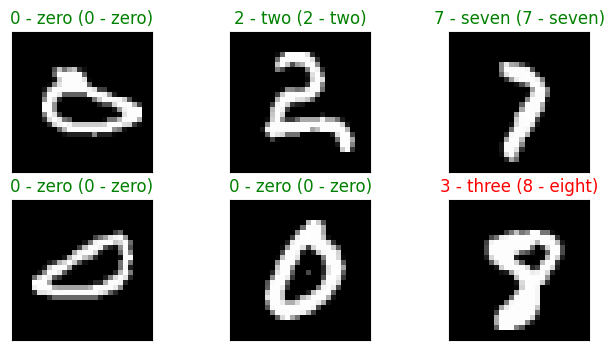

In [71]:
Test_plot(load_model, test_DL)

In [72]:
# 파라미터 수 구하기
def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

In [73]:
print(count_params(load_model))

79510
